In [1]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------- ----- 1.6/1.8 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas

  Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.2.5-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl (11.5 MB)
Using cached numpy-2.2.5-cp313-cp313-win_amd64.whl (12.6 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install matplotlib

  Using cached matplotlib-3.10.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp313-cp313-win_amd64.whl.metadata (104 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp313-cp313-win_amd64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp313-cp313-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl (71 kB)
Using cached pillow-11.2.1-cp313-cp313-win_amd64.whl (2.7 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
Note: you may need to restart the kernel to use updated packages.

Step 1: Merge SPI and NDVI Data

In [1]:
import pandas as pd

# Load SPI and NDVI data
spi_df = pd.read_csv("Data/Data for SPI/Region wise SPI/All Region SPI csv files/Cape_York_Peninsula_monthly_mean_spi.csv")
ndvi_df = pd.read_csv("Data/MODIS/NDVI csv/Cape_York_Peninsula_ndvi.csv")

# Clean SPI
spi_df = spi_df.rename(columns={"Mean_SPI": "SPI"})
spi_df['Date'] = pd.to_datetime(spi_df['Month'])

# Clean NDVI
ndvi_df = ndvi_df.rename(columns={"year": "Year", "month": "Month", "mean_ndvi": "NDVI"})
ndvi_df['Date'] = pd.to_datetime(dict(year=ndvi_df["Year"], month=ndvi_df["Month"], day=1))

# Merge
df = pd.merge(spi_df[["Date", "SPI"]], ndvi_df[["Date", "NDVI"]], on="Date").sort_values("Date")

# Save merged
df.to_csv("Data/Merged SPI & NDVI/Cape_York_Peninsula_merged_spi_ndvi.csv", index=False)


Step 2: Visualize SPI and NDVI (Full Period)

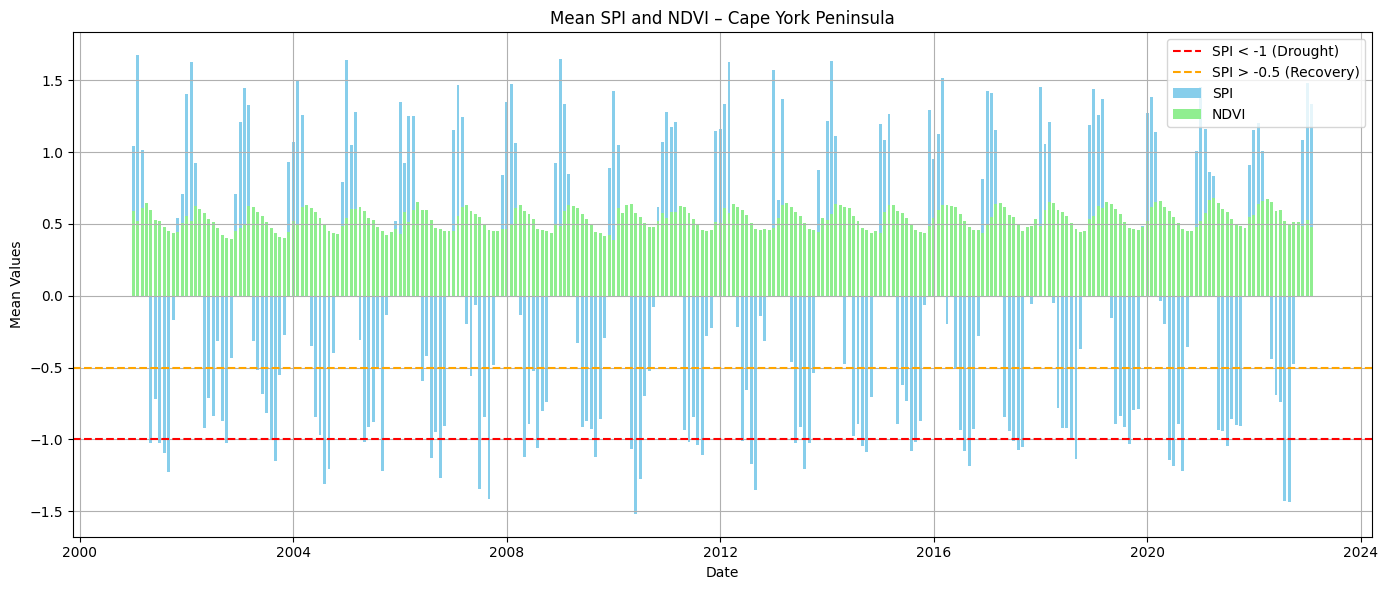

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(df['Date'], df['SPI'], width=20, label='SPI', color='skyblue')
plt.bar(df['Date'], df['NDVI'], width=20, label='NDVI', color='lightgreen')
plt.axhline(y=-1, color='red', linestyle='--', label='SPI < -1 (Drought)')
plt.axhline(y=-0.5, color='orange', linestyle='--', label='SPI > -0.5 (Recovery)')
plt.title('Mean SPI and NDVI – Cape York Peninsula')
plt.xlabel('Date')
plt.ylabel('Mean Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Step 3: Detect Recovery Events & Lags

In [5]:
recovery_dates = []
recovery_lags = []
ndvi_threshold = 0.03  # NDVI increase threshold

spi = df['SPI'].values
ndvi = df['NDVI'].values
dates = df['Date'].values

for i in range(2, len(spi) - 6):  # buffer for 6-month lookahead
    if spi[i - 1] < -1 and spi[i] > -0.5:
        ndvi_start = ndvi[i]
        for lag in range(1, 3):
            if ndvi[i + lag] - ndvi_start >= ndvi_threshold:
                recovery_lags.append(lag)
                recovery_dates.append(dates[i])
                break


Step 4: Plot Full Bar Chart + Recovery Events

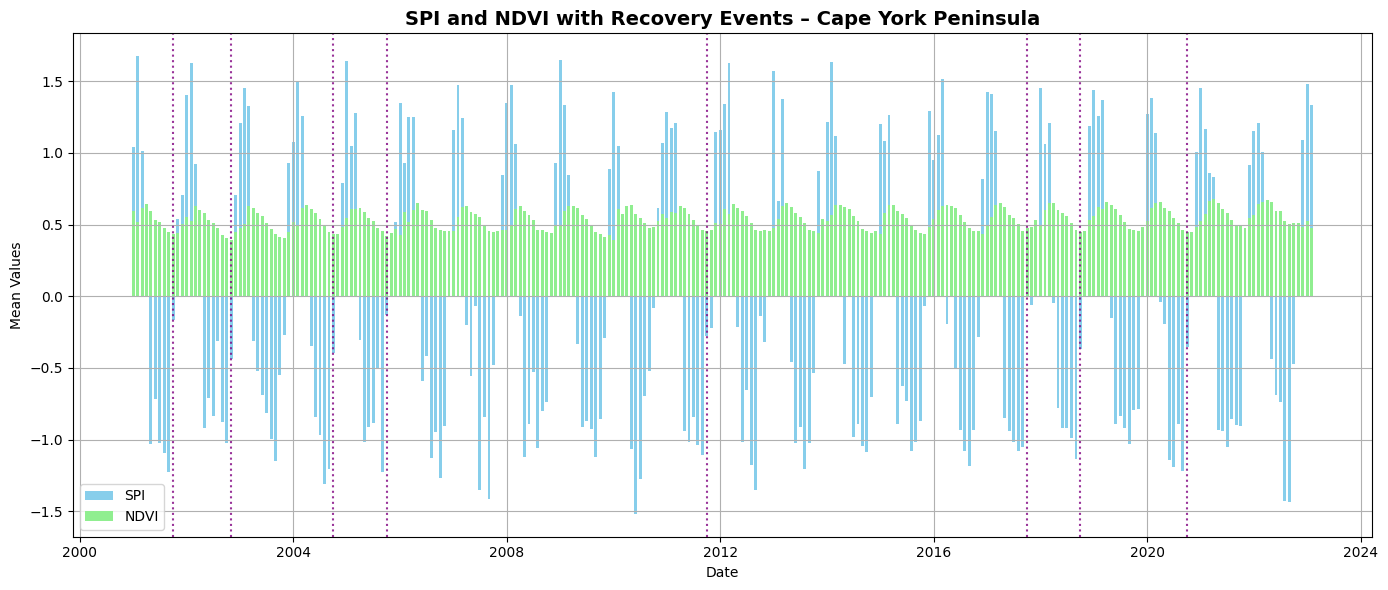

In [6]:
plt.figure(figsize=(14, 6))
plt.bar(df['Date'], df['SPI'], width=20, label='SPI', color='skyblue')
plt.bar(df['Date'], df['NDVI'], width=20, label='NDVI', color='lightgreen')
for date in recovery_dates:
    plt.axvline(x=date, color='purple', linestyle=':', alpha=0.8, linewidth=1.5)
plt.title('SPI and NDVI with Recovery Events – Cape York Peninsula', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Mean Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Step 5: Zoomed-In View of One Recovery Event

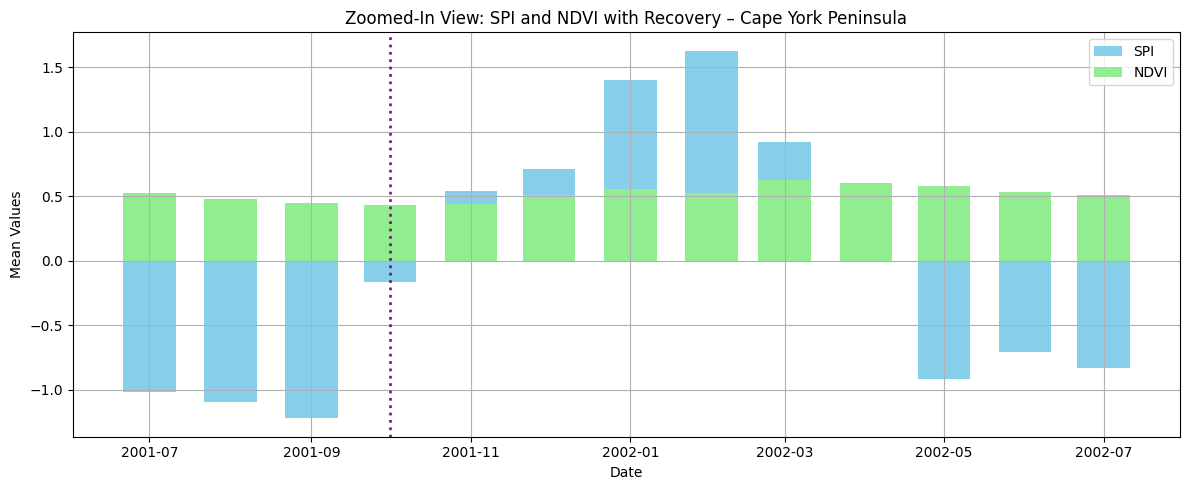

In [8]:
# Focus on first recovery event ± 3 to +9 months
focus_start_date = recovery_dates[0] - pd.DateOffset(months=3)
focus_end_date = recovery_dates[0] + pd.DateOffset(months=9)

focused_df = df[(df['Date'] >= focus_start_date) & (df['Date'] <= focus_end_date)]

plt.figure(figsize=(12, 5))
plt.bar(focused_df['Date'], focused_df['SPI'], width=20, label='SPI', color='skyblue')
plt.bar(focused_df['Date'], focused_df['NDVI'], width=20, label='NDVI', color='lightgreen')
for date in recovery_dates:
    if focus_start_date <= date <= focus_end_date:
        plt.axvline(x=date, color='purple', linestyle=':', alpha=0.9, linewidth=2)
plt.title('Zoomed-In View: SPI and NDVI with Recovery – Cape York Peninsula')
plt.xlabel('Date')
plt.ylabel('Mean Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Step 6: Recovery Lag Histogram & Summary

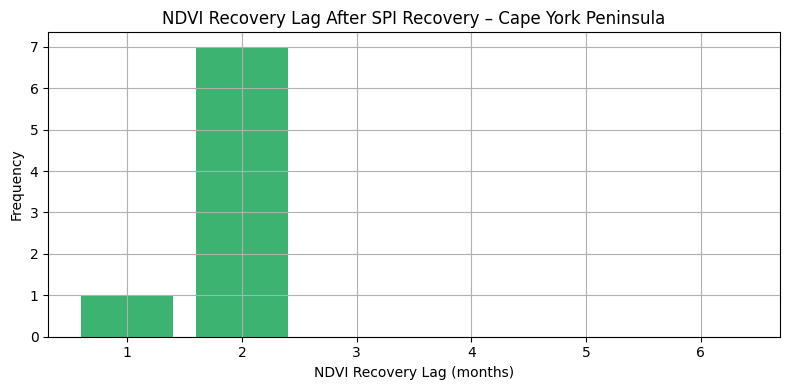

{'Average Recovery Lag': 1.88, 'Minimum Recovery Lag': 1, 'Total Recovery Events Detected': 8}


In [9]:
# Histogram
plt.figure(figsize=(8, 4))
plt.hist(recovery_lags, bins=range(1, 8), align='left', color='mediumseagreen', rwidth=0.8)
plt.xlabel('NDVI Recovery Lag (months)')
plt.ylabel('Frequency')
plt.title('NDVI Recovery Lag After SPI Recovery – Cape York Peninsula')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print recovery summary
avg_lag = round(sum(recovery_lags) / len(recovery_lags), 2) if recovery_lags else None
min_lag = min(recovery_lags) if recovery_lags else None
total_events = len(recovery_lags)

recovery_lag_results = {
    "Average Recovery Lag": avg_lag,
    "Minimum Recovery Lag": min_lag,
    "Total Recovery Events Detected": total_events
}

print(recovery_lag_results)


One Set Go

In [76]:
# Final version of the reusable function that generates 4 plots:
# 1. Full bar chart without recovery lines
# 2. Full bar chart with recovery lines and thresholds
# 3. Zoomed-in recovery view
# 4. Recovery lag histogram

def analyze_spi_ndvi_recovery(spi_path, ndvi_path, region_name, save_dir=None):
    import pandas as pd
    import matplotlib.pyplot as plt

    spi_df = pd.read_csv(spi_path)
    ndvi_df = pd.read_csv(ndvi_path)

    spi_df = spi_df.rename(columns={"Mean_SPI": "SPI"})
    spi_df['Date'] = pd.to_datetime(spi_df['Month'])

    ndvi_df = ndvi_df.rename(columns={"year": "Year", "month": "Month", "mean_ndvi": "NDVI"})
    ndvi_df['Date'] = pd.to_datetime(dict(year=ndvi_df["Year"], month=ndvi_df["Month"], day=1))

    df = pd.merge(spi_df[["Date", "SPI"]], ndvi_df[["Date", "NDVI"]], on="Date").sort_values("Date")

    if save_dir:
        df.to_csv(f"{save_dir}/{region_name}_merged_spi_ndvi.csv", index=False)

    recovery_dates = []
    recovery_lags = []
    ndvi_threshold = 0.05
    spi = df['SPI'].values
    ndvi = df['NDVI'].values
    dates = df['Date'].values

    for i in range(2, len(spi) - 6):
        if spi[i - 1] < -1 and spi[i] > -0.5:
            ndvi_start = ndvi[i]
            for lag in range(1, 7):
                if ndvi[i + lag] - ndvi_start >= ndvi_threshold:
                    recovery_lags.append(lag)
                    recovery_dates.append(dates[i])
                    break

    # Plot 1: Full bar chart without recovery lines
    plt.figure(figsize=(14, 6))
    plt.bar(df['Date'], df['SPI'], width=20, label='SPI', color='skyblue')
    plt.bar(df['Date'], df['NDVI'], width=20, label='NDVI', color='lightgreen')
    plt.axhline(y=-1, color='red', linestyle='--', label='SPI < -1 (Drought Threshold)')
    plt.axhline(y=-0.5, color='orange', linestyle='--', label='SPI > -0.5 (Recovery Threshold)')
    plt.title(f'{region_name} – SPI and NDVI (No Recovery Lines)')
    plt.xlabel('Date')
    plt.ylabel('Mean Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/{region_name}_full_bar_chart_no_recovery.png")
    # plt.show()

    # Plot 2: Full bar chart with recovery lines
    plt.figure(figsize=(14, 6))
    plt.bar(df['Date'], df['SPI'], width=20, label='SPI', color='skyblue')
    plt.bar(df['Date'], df['NDVI'], width=20, label='NDVI', color='lightgreen')
    for date in recovery_dates:
        plt.axvline(x=date, color='purple', linestyle=':', alpha=0.8, linewidth=1.5)
    plt.axhline(y=-1, color='red', linestyle='--', label='SPI < -1 (Drought Threshold)')
    plt.axhline(y=-0.5, color='orange', linestyle='--', label='SPI > -0.5 (Recovery Threshold)')
    plt.title(f'{region_name} – SPI and NDVI with Recovery Events')
    plt.xlabel('Date')
    plt.ylabel('Mean Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/{region_name}_full_recovery_plot.png")
    # plt.show()

    # Plot 3: Zoomed-in view of first recovery
    if recovery_dates:
        focus_start = recovery_dates[0] - pd.DateOffset(months=3)
        focus_end = recovery_dates[0] + pd.DateOffset(months=9)
        focus_df = df[(df['Date'] >= focus_start) & (df['Date'] <= focus_end)]

        plt.figure(figsize=(12, 5))
        plt.bar(focus_df['Date'], focus_df['SPI'], width=20, label='SPI', color='skyblue')
        plt.bar(focus_df['Date'], focus_df['NDVI'], width=20, label='NDVI', color='lightgreen')
        plt.axvline(x=recovery_dates[0], color='purple', linestyle=':', alpha=0.9, linewidth=2)
        plt.title(f'{region_name} – Zoomed-In SPI & NDVI Recovery')
        plt.xlabel('Date')
        plt.ylabel('Mean Values')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if save_dir:
            plt.savefig(f"{save_dir}/{region_name}_zoomed_recovery_plot.png")
        # plt.show()

    # Plot 4: Recovery lag histogram
    plt.figure(figsize=(8, 4))
    plt.hist(recovery_lags, bins=range(1, 8), align='left', color='mediumseagreen', rwidth=0.8)
    plt.xlabel('NDVI Recovery Lag (months)')
    plt.ylabel('Frequency')
    plt.title(f'{region_name} – NDVI Recovery Lag Histogram')
    plt.grid(True)
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/{region_name}_recovery_lag_histogram.png")
    # plt.show()

    # Return summary
    avg_lag = round(sum(recovery_lags) / len(recovery_lags), 2) if recovery_lags else None
    min_lag = min(recovery_lags) if recovery_lags else None
    result = {
        "Region": region_name,
        "Average Recovery Lag": avg_lag,
        "Minimum Recovery Lag": min_lag,
        "Total Recovery Events Detected": len(recovery_lags)
    }
    return result


{'Region': 'Wet Tropics', 'Average Recovery Lag': 2.87, 'Minimum Recovery Lag': 1, 'Total Recovery Events Detected': 15}


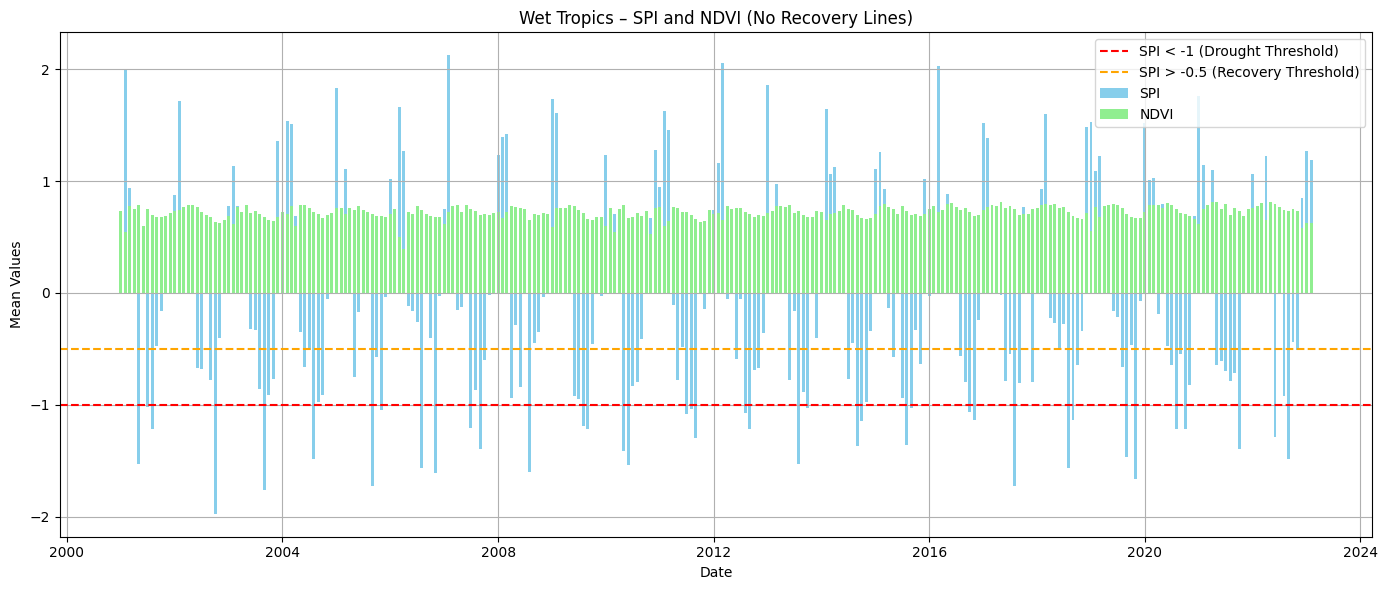

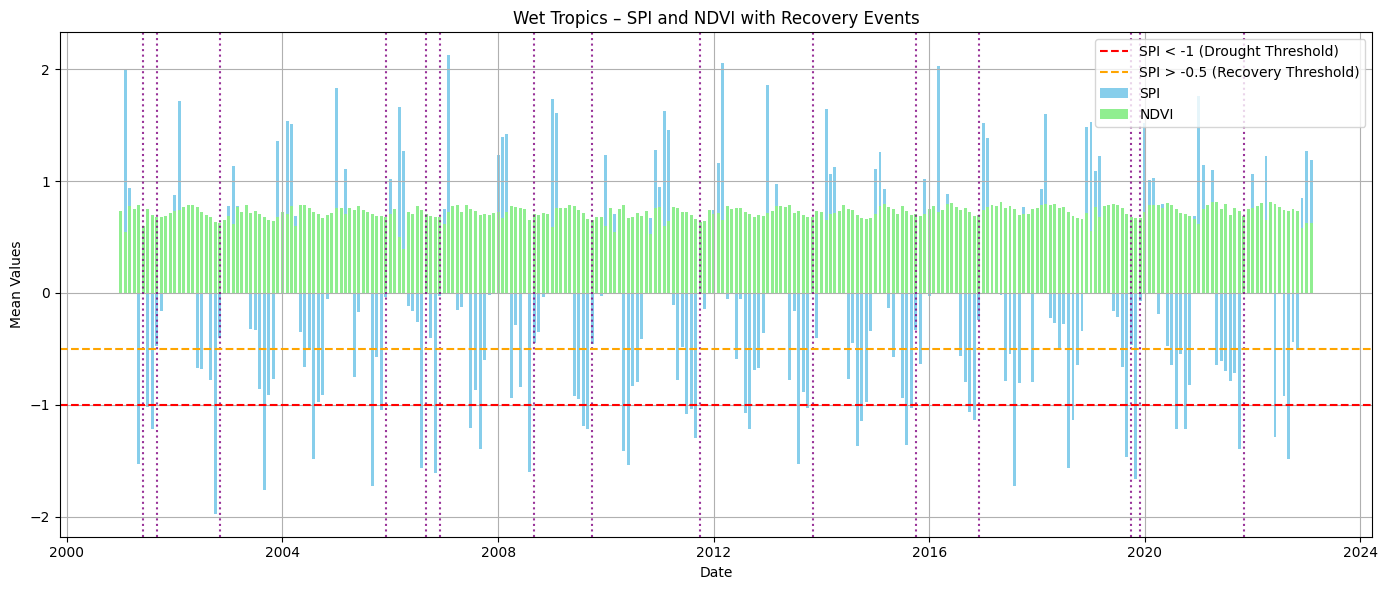

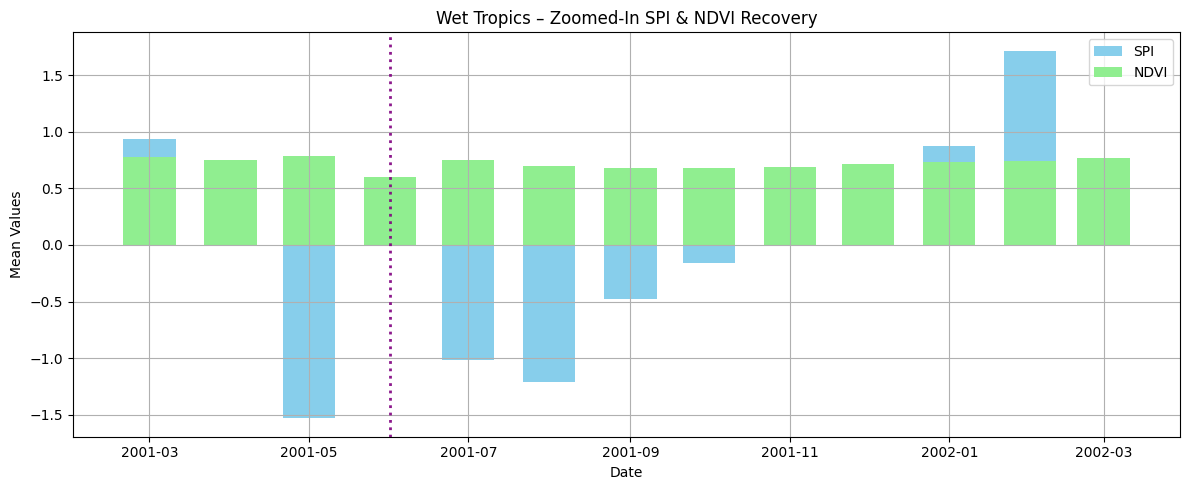

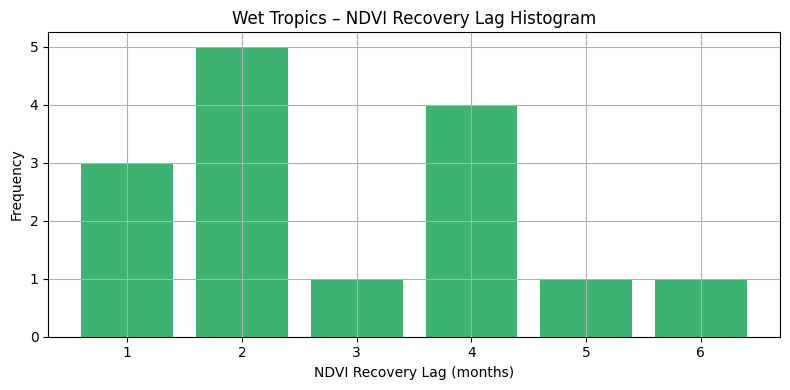

In [77]:
result = analyze_spi_ndvi_recovery(
    spi_path= r"Data\Data for SPI\Region wise SPI\All Region SPI csv files\Wet_Tropics_monthly_mean_spi.csv",
    ndvi_path= r"Data\MODIS\NDVI csv\Wet_Tropics_ndvi.csv",
    region_name="Wet Tropics",
    save_dir= r"Figures\SPI vs NDVI\0.5\Wet_Tropics"
)

print(result)


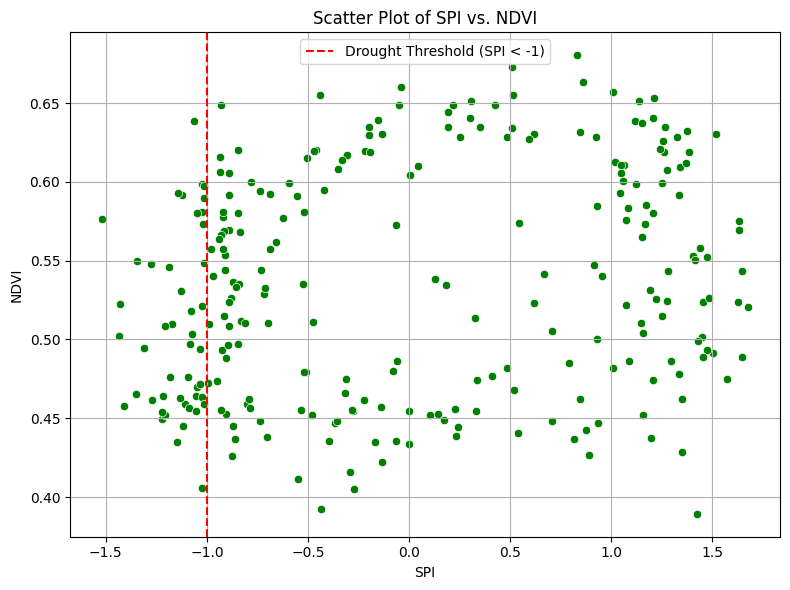

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume `df` is the merged SPI + NDVI data for a region
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='SPI', y='NDVI', color='green')
plt.axvline(x=-1, color='red', linestyle='--', label='Drought Threshold (SPI < -1)')
plt.title('Scatter Plot of SPI vs. NDVI')
plt.xlabel('SPI')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


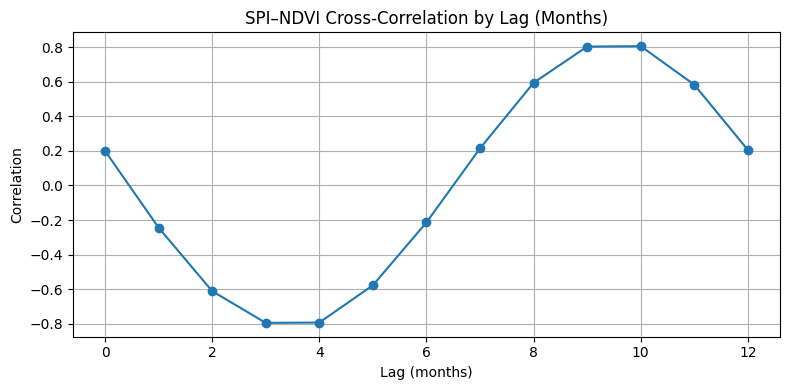

In [34]:
import numpy as np

# Calculate cross-correlation
spi_series = df['SPI'] - df['SPI'].mean()
ndvi_series = df['NDVI'] - df['NDVI'].mean()
correlations = [spi_series.corr(ndvi_series.shift(lag)) for lag in range(0, 13)]

# Plot lagged correlation
plt.figure(figsize=(8, 4))
plt.plot(range(0, 13), correlations, marker='o')
plt.title('SPI–NDVI Cross-Correlation by Lag (Months)')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/sj/0lwb59cd0px29vvpktccpgrm0000gn/T/ipykernel_33838/2659279575.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='SPI_Class', y='NDVI', palette='YlGn')


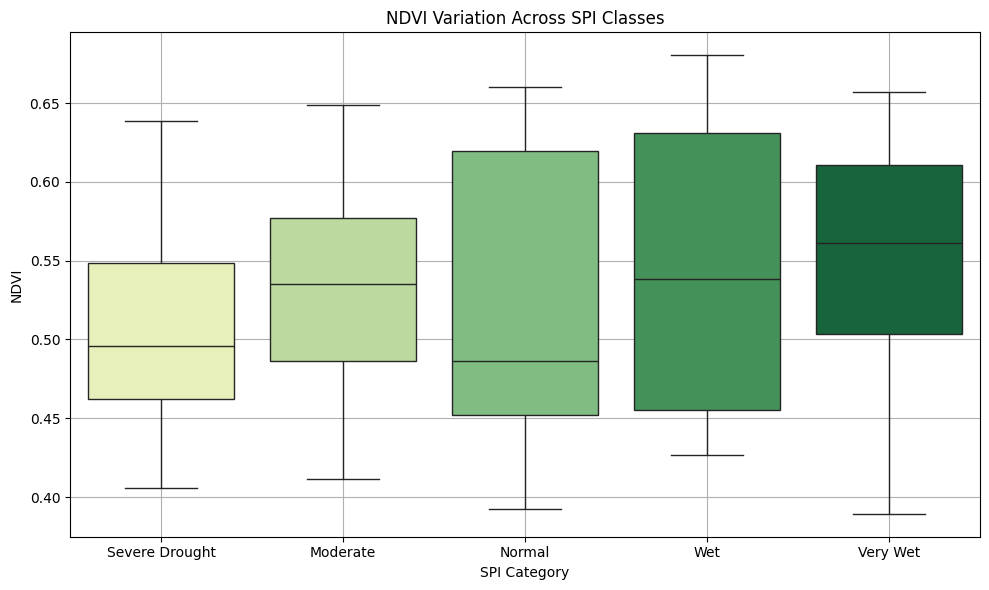

In [35]:
df['SPI_Class'] = pd.cut(df['SPI'], bins=[-np.inf, -1, -0.5, 0, 1, np.inf], labels=['Severe Drought', 'Moderate', 'Normal', 'Wet', 'Very Wet'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='SPI_Class', y='NDVI', palette='YlGn')
plt.title('NDVI Variation Across SPI Classes')
plt.xlabel('SPI Category')
plt.ylabel('NDVI')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, _ = pearsonr(df['SPI'], df['NDVI'])
spearman_corr, _ = spearmanr(df['SPI'], df['NDVI'])

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")


Pearson correlation: 0.200
Spearman correlation: 0.202
